   constructorResultsId  raceId  constructorId  points_constructor status  \
0                     1      18              1                14.0     \N   
1                     1      18              1                14.0     \N   
2                    14      19              1                10.0     \N   
3                    14      19              1                10.0     \N   
4                    25      20              1                 4.0     \N   

   resultId  driverId number  grid position_constructor ...  sprint_time  \
0         1         1     22     1                    1 ...           \N   
1         5         5     23     3                    5 ...           \N   
2        25         5     23     8                    3 ...           \N   
3        27         1     22     9                    5 ...           \N   
4        49         5     23     5                    5 ...           \N   

   constructorRef   name_y  nationality                                 url_y  \

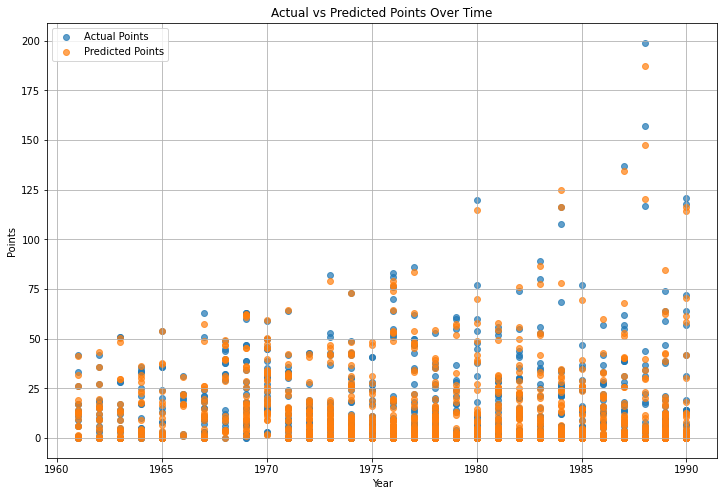

In [7]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

constructor_results = pd.read_csv('constructor_results.csv')
df = pd.DataFrame(constructor_results)
constructor_standings = pd.read_csv('constructor_standings.csv')
constructors = pd.read_csv('constructors.csv')
races = pd.read_csv('races.csv')
results = pd.read_csv('results.csv')

#merging of data frames to get one dataset with desired columns for the model
df = pd.merge(constructor_results, results, on=['raceId', 'constructorId'], suffixes=('_constructor', '_results'))
df = pd.merge(df, races, on='raceId')
df = pd.merge(df, constructors, on='constructorId')
df = pd.merge(df, constructor_standings, on=['raceId', 'constructorId'], suffixes=('_constructor', '_standings'))

#first 5 rows of the merged dataframe
print(df.head())

#descriptive statistics for each column of the dataframe
print(df.describe())

#changing the model's dataset to only include data between the years 1961 and 1990
df = df[(df['year'] >= 1961) & (df['year'] <= 1990)]

#desired features for the model's dataset
selected_columns = [
    'grid', 'laps',  
    'position_constructor',   
    'year', 'round', 'circuitId', 'points', 'position_standings', 'wins'  
]

#model only has desired features
df = df[selected_columns]

#converting categorical columns into numerical columns
df = pd.get_dummies(df)

#dropping all rows where at least 1 element is missing
#df = df.dropna()

#dataset of the predictor variables
X = df.drop('points', axis=1)

#series representing the target variable
y = df['points']

#evening the distribution of values of the predictor variable
y= np.log1p(y)

#range of hyperparameters to test on the model
param_grid = {
    'n_estimators': [50, 100, 200],       # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],      # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],     # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]        # Minimum number of samples required to be at a leaf node
}

#machine learning model object
model = RandomForestRegressor()


#grid search CV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2)

#training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#fitting the training data to the model 
grid_search.fit(X_train, y_train)

#best possible combination of hyperparameters for the model
best_params = grid_search.best_params_

#model that performed the best during hyperparameter tuning
best_estimator = grid_search.best_estimator_

#predicted values
y_pred = grid_search.predict(X_test)

#efficiency of model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Best Parameters: {best_params}')
print(f'Best Estimator: {best_estimator}')

"""
scatter plot to compare all actual points to their corresponding
predicted points between the years of 1961 and 1990
"""

plt.figure(figsize=(12, 8))
plt.scatter(X_test['year'], np.expm1(y_test), label='Actual Points', alpha=0.7)
plt.scatter(X_test['year'], np.expm1(y_pred), label='Predicted Points', alpha=0.7)
plt.title('Actual vs Predicted Points Over Time')
plt.xlabel('Year')
plt.ylabel('Points')
plt.legend()
plt.grid(True)
plt.show()
